In [32]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random


In [33]:
class Value:
    def __init__(self,data, _children=(), _op="", _label = ""):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self._label = _label
        self.grad = 0
        
    def __repr__(self):
        return f"Value(data = {self.data} )"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other): 
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad  * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (float, int))
        out = Value(self.data**other, (self,), f"**{other}")
        
        def _backward():
            self.grad += (other)*(self.data **(other -1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        return self * (other**-1)
    
    
    def exp(self):
        x = self.data
        t = (math.exp(x))
        out = Value(t, (self, ), "exp")
        def _backward():
            self.grad += t 
        out._backward = _backward
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()
    
    
    
    


In [34]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [35]:
def lol():
    a = Value(2.0); a._label = "a"
    b =  Value(3.0);b._label = "b"
    c = Value(-10.0);c._label = "c"
    e = a*b; e._label="e"
    d = e + c; d._label ="d"
    f = Value(2.0, _label = "f")
    L = d*f;L._label = "L"
    
lol()

In [36]:
L.grad = 1.0


NameError: name 'L' is not defined

In [37]:
draw_dot(L)

NameError: name 'L' is not defined

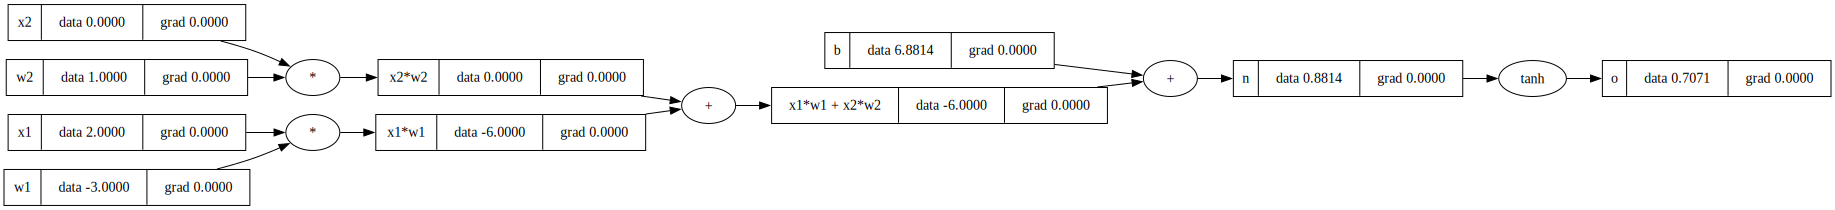

In [38]:
# inputs x1,x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
# weights w1,w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')
# bias of the neuron
b = Value(6.8813735870195432, _label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'

o = n.tanh(); o._label = 'o'
draw_dot(o)

In [39]:
o.grad = 1.0

In [40]:
o._backward()

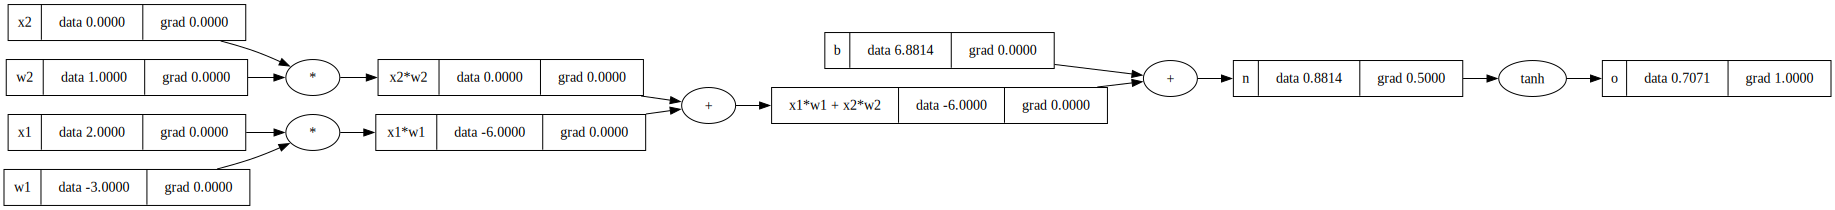

In [41]:
draw_dot(o)

In [42]:
topo= []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    
build_topo(o)
topo
            

[Value(data = 6.881373587019543 ),
 Value(data = -3.0 ),
 Value(data = 2.0 ),
 Value(data = -6.0 ),
 Value(data = 0.0 ),
 Value(data = 1.0 ),
 Value(data = 0.0 ),
 Value(data = -6.0 ),
 Value(data = 0.8813735870195432 ),
 Value(data = 0.7071067811865476 )]

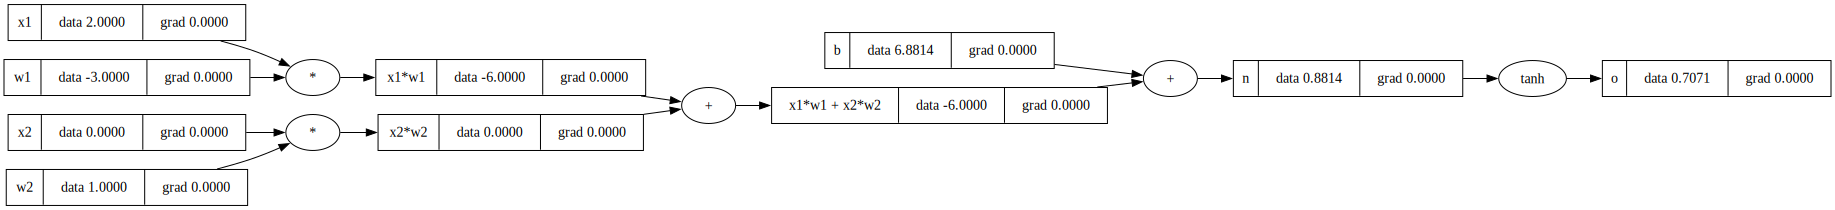

In [43]:
# inputs x1,x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
# weights w1,w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')
# bias of the neuron
b = Value(6.8813735870195432, _label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'

o = n.tanh(); o._label = 'o'
draw_dot(o)

In [44]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    
class MLP:
    # Here Nouts is a list of number of neurons in each layer
    # range(nouts) refers to number of layers
    # sz in a lis [nin, list.nouts] imagine input of first layer to second
    # and number of neurons in 2nd is no. of inputs in 3rd so sz[i] and sz[i+1]
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts)) ]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    ## We are outputing final value of the loop cause we want the result of the final layer
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
x = [2.0, 3.0, -7.0]
y = MLP(3, [4,4,1])
y(x)



Value(data = -0.5407612131541617 )

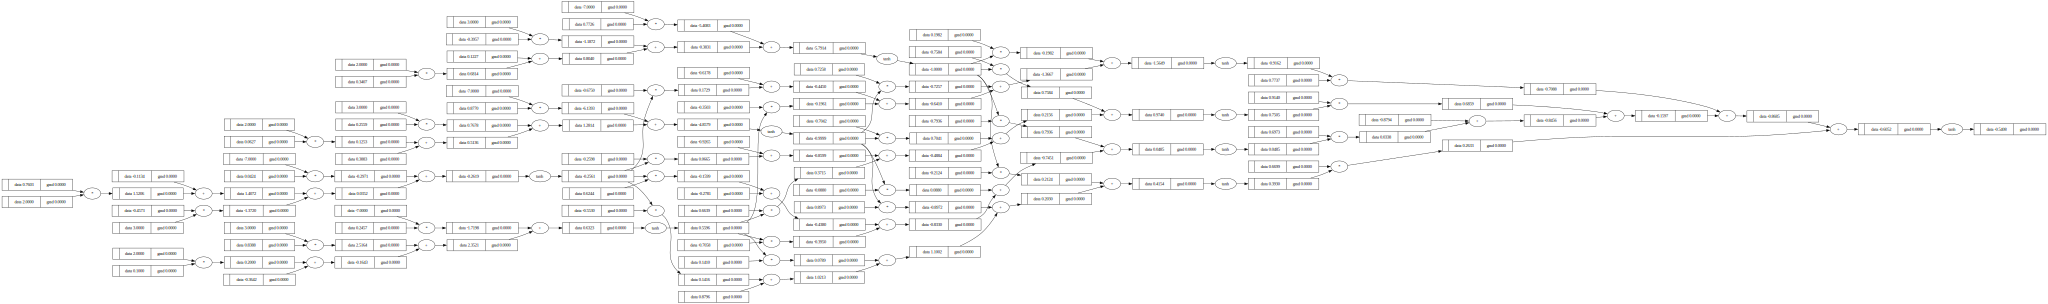

In [45]:
draw_dot(y(x))

In [46]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]



In [52]:
for k in range(50):
  
  # forward pass
  ypred = [y(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in y.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in y.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.017332839455295086
1 0.016484580509209992
2 0.015713540048635583
3 0.015009736800706854
4 0.014364829817791618
5 0.01377179581637269
6 0.013224679657606389
7 0.012718399352276106
8 0.012248592194877377
9 0.011811492262219921
10 0.011403832072313148
11 0.011022763028756464
12 0.010665790599041033
13 0.010330721143045101
14 0.010015618023479226
15 0.009718765164145528
16 0.009438636624281222
17 0.009173871063064033
18 0.008923250202647061
19 0.008685680578967835
20 0.008460178010226499
21 0.008245854323049796
22 0.00804190596313064
23 0.00784760418593278
24 0.0076622865779145425
25 0.007485349702719652
26 0.0073162427022495265
27 0.0071544617112626946
28 0.006999544967538388
29 0.006851068518768062
30 0.006708642443050837
31 0.006571907512827617
32 0.006440532242819499
33 0.0063142102714590625
34 0.006192658032745555
35 0.006075612681690139
36 0.005962830241753005
37 0.005854083947090907
38 0.005749162756166551
39 0.00564787001643764
40 0.005550022262539535
41 0.005455448132671912
42

In [53]:
ypred

[Value(data = 0.9684638994757497 ),
 Value(data = -0.984337550847469 ),
 Value(data = -0.953157301732949 ),
 Value(data = 0.9630491744439031 )]

Value(data = 0.32048923114826366 )